<a href="https://colab.research.google.com/github/isaacdono/EA991-Atividade_02/blob/main/solucao/atividade_02_247175.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 02: Reconhecimento de Atividades Humanas com kNN, SVM e _Random Forest_

<img src="https://github.com/EA991-Lab/utils/blob/main/figs/HAR_acc_gyr.png?raw=true">

*Dataset*: DAGHAR - https://zenodo.org/records/13987073

Github: https://github.com/H-IAAC/DAGHAR

O *benchmark* DAGHAR é uma coleção curada de conjuntos de dados projetada para estudos de adaptação de domínio e generalização de domínio em tarefas ligadas ao reconhecimento de atividades humanas (HAR, do inglês *human activity recognition*). As amostras disponíveis contêm dados brutos de sensores inerciais (acelerômetro e giroscópio) provenientes exclusivamente de *smartphones*.

Nesta atividade, vamos trabalhar com a *baseline view* do DAGHAR, que preserva ao máximo as características dos *datasets* originais (como a taxa de amostragem).

**Informações padronizadas:**

- 6 classes

| Rótulo    | Atividade |
| :----:    |    :---   
| 0   | Estar sentado       
| 1   | Ficar em pé        
| 2   | Caminhar        
| 3   | Subir escadas      
| 4   | Descer escadas
| 5   | Correr      

- Cada amostra contém janelas de 3 segundos (sem sobreposição) concatenadas de Acc-x, Acc-y, Acc-z, Gyr-x, Gyr-y, Gyr-z.



## Preâmbulo: Baixando o DAGHAR _baseline_

In [1]:
import requests
import os
from pathlib import Path
from zipfile import ZipFile

# Caminho para a pasta que conterá o dataset
data_path = Path("data/")

def get_DARGHAR_data():
    if not os.path.exists(data_path):
        os.makedirs("data/", exist_ok=True)

        # Baixando o dataset do Zenodo
        data_url = "https://zenodo.org/records/13987073/files/baseline_view.zip?download=1"
        print(f"Baixando dados de {data_url}...")

        #Baseline view
        with open("baseline_view.zip", "wb") as f:
            request = requests.get(data_url)
            f.write(request.content)

        # Unzip
        targ_dir = "data"
        print(f"Extraindo dados para {targ_dir}...")
        with ZipFile("baseline_view.zip") as zip_ref:
            zip_ref.extractall(targ_dir)
    else:
        print("Dataset já baixado!")

#Baixando o dataset DAGHAR completo
get_DARGHAR_data()

Baixando dados de https://zenodo.org/records/13987073/files/baseline_view.zip?download=1...
Extraindo dados para data...


## Parte 1: Conhecendo detalhes do problema e do *dataset*

Escolha um conjunto de dados que compõe o DAGHAR e faça o carregamento das partições de treinamento, validação e teste.

**Passos:**
- definir o nome do subdiretório correspondente ao *dataset*;
- ler os arquivos `train.csv`, `validation.csv` e `test.csv`.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Caminho para a pasta que conterá o dataset
folder = "KuHar" # KuHar, MotionSense, RealWorld_thigh
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

print(f"Dimensão do dataset de treinamento: {data_train.shape}")
print(f"Dimensão do dataset de validação: {data_val.shape}")
print(f"Dimensão do dataset de teste: {data_test.shape}")


Dimensão do dataset de treinamento: (1386, 1812)
Dimensão do dataset de validação: (426, 1812)
Dimensão do dataset de teste: (144, 1812)


In [2]:
#Lista com os nomes das classes na ordem correspondente aos rótulos numéricos
class_names = ['Sitting','Standing','Walking','Upstairs','Downstairs','Running']

#mapeamento dos rótulos padronizados para os nomes das classes no DAGHAR
label_map = {0:'Sitting',1:'Standing',2:'Walking',3:'Upstairs',4:'Downstairs',5:'Running'}

O `DataFrame` correspondente a cada *dataset* contém colunas adicionais com informações específicas (como índice de usuário) que não serão exploradas na atividade. Por isso, é necessário realizar uma limpeza inicial a fim de reter apenas as medidas de acelerômetro e giroscópio juntamente com o rótulo da atividade.

In [ ]:
# Limpeza do df

dfs = [data_train, data_val, data_test]
for x in dfs:
    x.drop(columns=['gyro-start-time', 'gyro-end-time', 'index', 'user', 'serial', 'accel-start-time', 'accel-end-time', 'csv',
       'timestamp diff', 'activity code', 'window'], inplace=True)

a) Sorteie aleatoriamente uma amostra de cada classe e apresente as séries temporais correspondentes aos três eixos de acelerômetro e de giroscópio. Discuta brevemente o perfil das atividades com base nestas séries temporais.

In [ ]:
sample_list = []
sample_cols = []

def get_samples():
    for activity_code in range(len(class_names)):
        # Sortear amostra aleatoria de treinamento
        sample = data_train[data_train['standard activity code'] == activity_code].sample(1)
        sample_list.append(sample)

    # Criar listas de colunas de acelerômetro e giroscópio
    sample_accel = [sample_list[0].filter(like=f'accel-{axis}-').columns for axis in 'xyz']
    sample_gyro = [sample_list[0].filter(like=f'gyro-{axis}-').columns for axis in 'xyz']

    sample_cols.append(sample_accel)
    sample_cols.append(sample_gyro)

get_samples() #

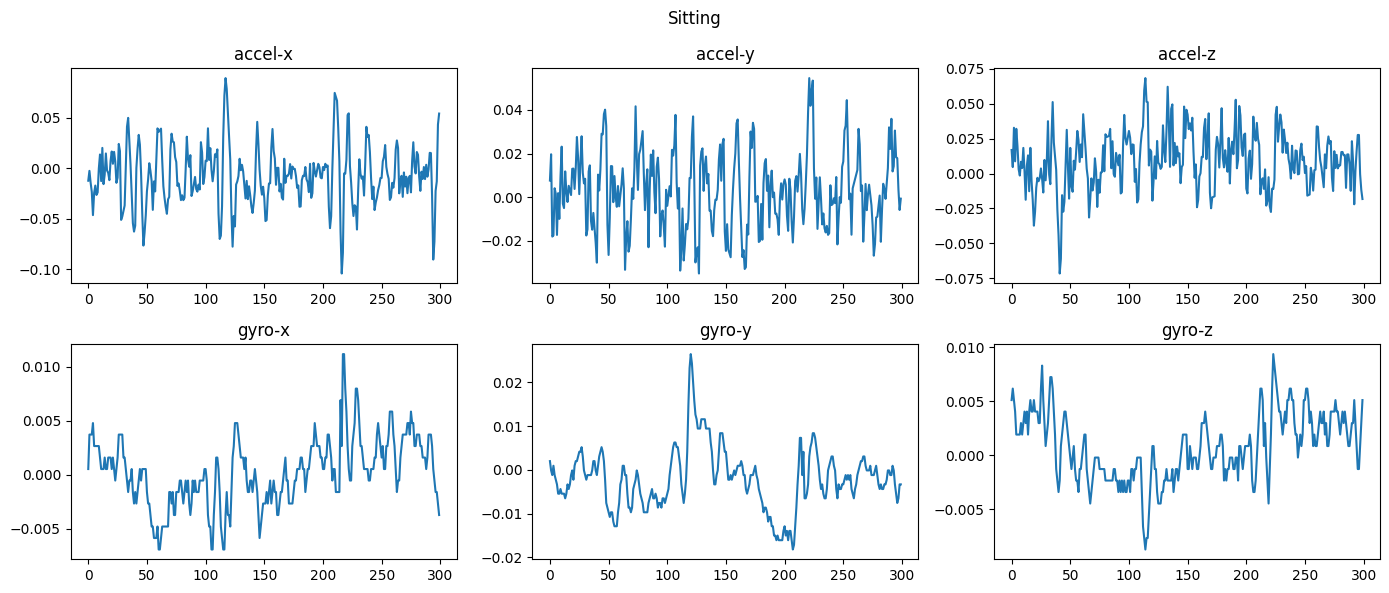

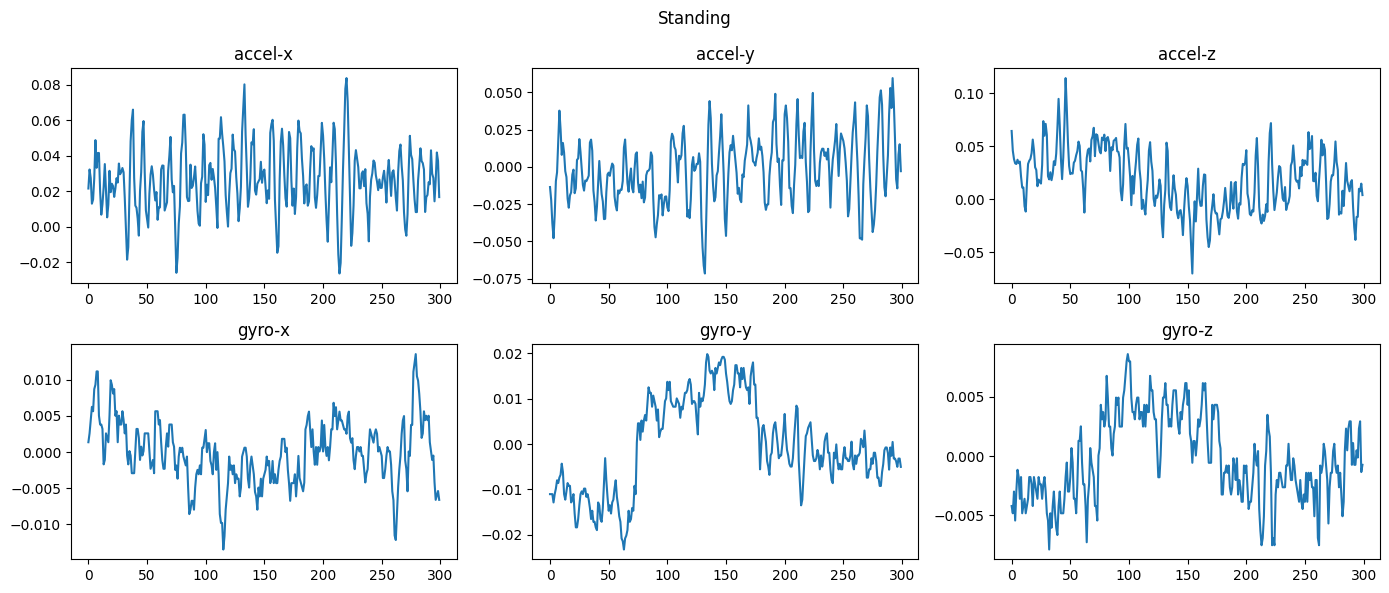

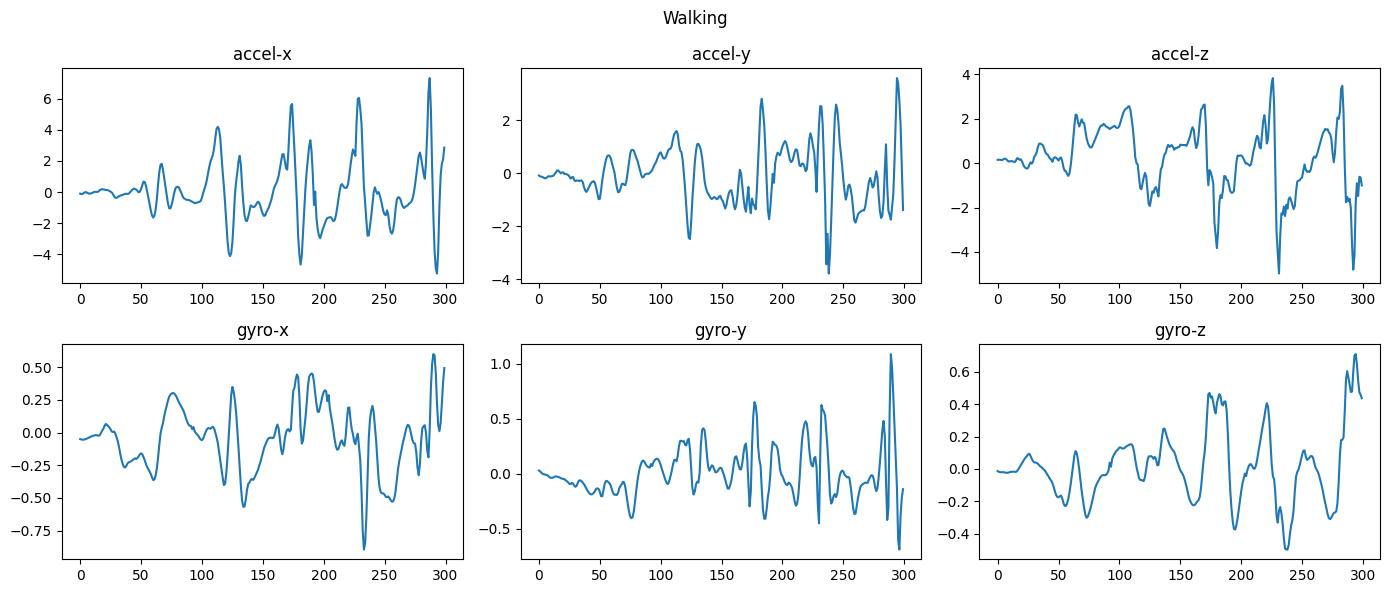

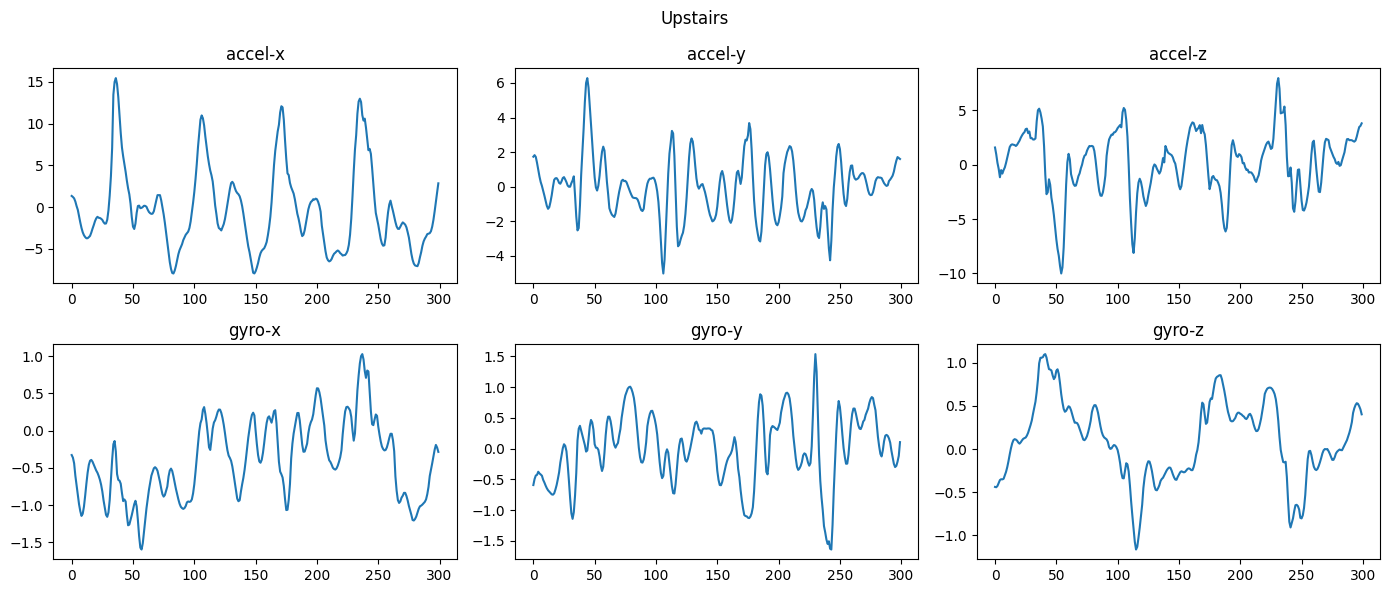

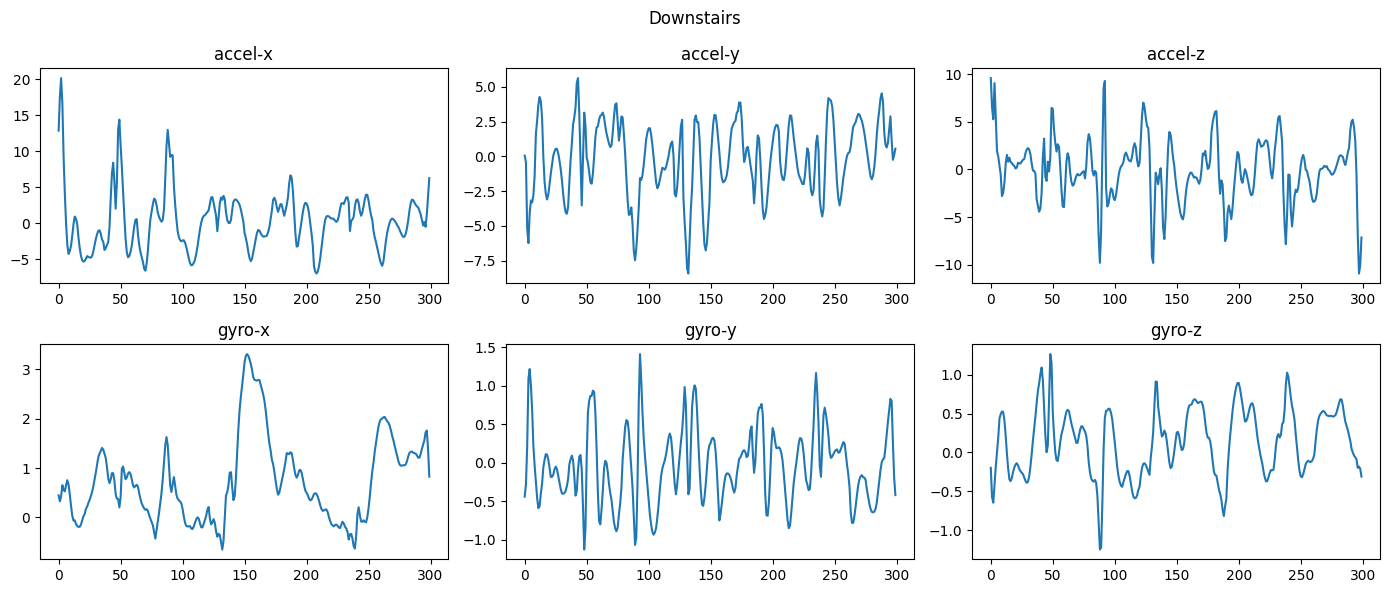

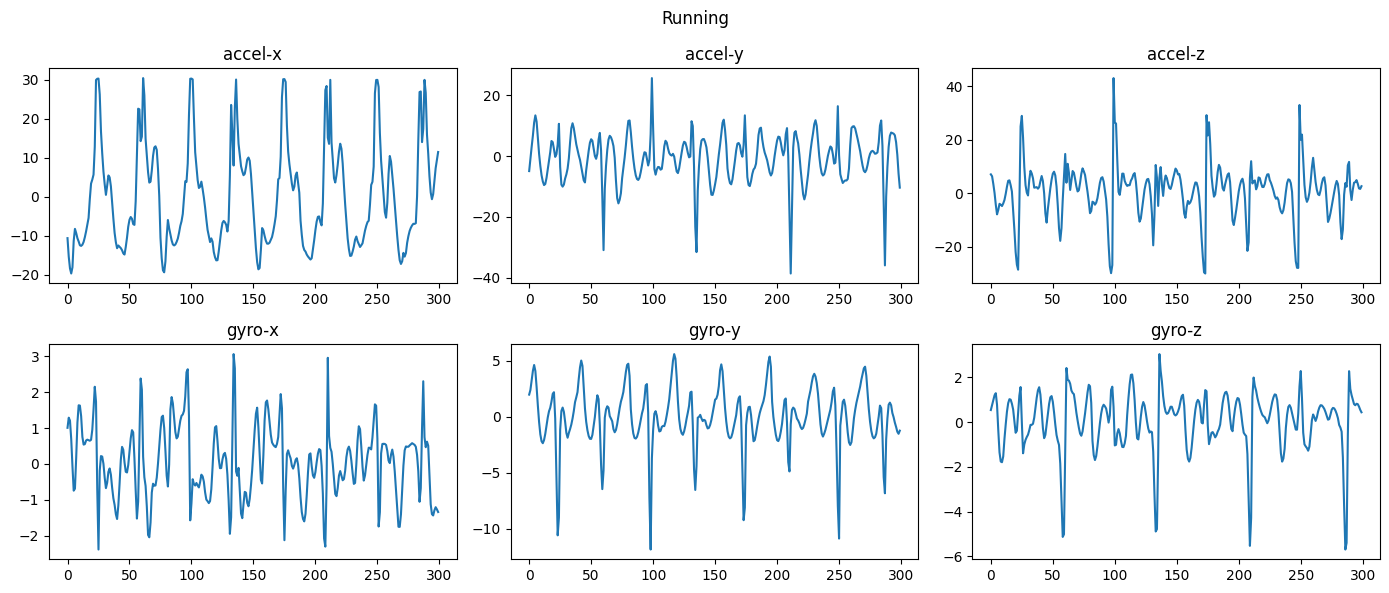

In [ ]:
def plot_sample_data(sample, columns, activity_code):
    fig, axs = plt.subplots(2, 3, figsize=(14, 6))  # 2 linhas: acel/gyro, 3 colunas: x/y/z
    fig.suptitle(class_names[activity_code])

    for i, sensor_group in enumerate(columns):  # i: 0=accel, 1=gyro
        for j, axis_columns in enumerate(sensor_group):  # j: 0=x, 1=y, 2=z
            axs[i, j].plot(sample.iloc[0][axis_columns].values)
            axs[i, j].set_title(f'{axis_columns[0].split("-")[0]}-{"xyz"[j]}')

    plt.tight_layout()
    plt.show()

for activity_code in range(len(class_names)):
    plot_sample_data(sample_list[activity_code], sample_cols, activity_code)

**COMENTÁRIO:** Nota-se um comportamento periódico nos gráficos, como em "Upstairs", o que é compatível com passos repetitivos durante a subida de escadas. Essa regularidade reforça a presença de padrões temporais característicos da atividade.

Além disso, a amplitude dos sinais é relativamente alta, indicando movimentos intensos. Isso contrasta com classes como "Sitting", onde a amplitude tende a ser baixa, refletindo pouca ou nenhuma movimentação.

b) No problema de HAR, a representação no domínio da frequência para cada sinal (Acc-x, Acc-y, ..., Gyr-z) tende a favorecer a separação das classes, levando a um agrupamento das amostras de acordo com a "energia" da atividade. Por isso, vamos aplicar a transformada de Fourier a cada sinal básico (Acc-x, Acc-y, $\ldots$, Gyr-z) e gerar um vetor de características formado pela concatenação da magnitude dos espectros:

$$\text{Vetor de atributos} = [\, |\text{DFT}(\text{Acc-x})|\;,\;|\text{DFT}(\text{Acc-y})|\;,\;|\text{DFT}(\text{Acc-z})|\;,\; |\text{DFT}(\text{Gyr-x})|\;,\; |\text{DFT}(\text{Gyr-y})|\;,\; |\text{DFT}(\text{Gyr-z})|]$$

Prepare, então, uma rotina que faça esta transformação das partições de treinamento, validação e teste. Em seguida, mostre a magnitude dos espectros das amostras selecionadas no item anterior (uma por atividade) e comente.

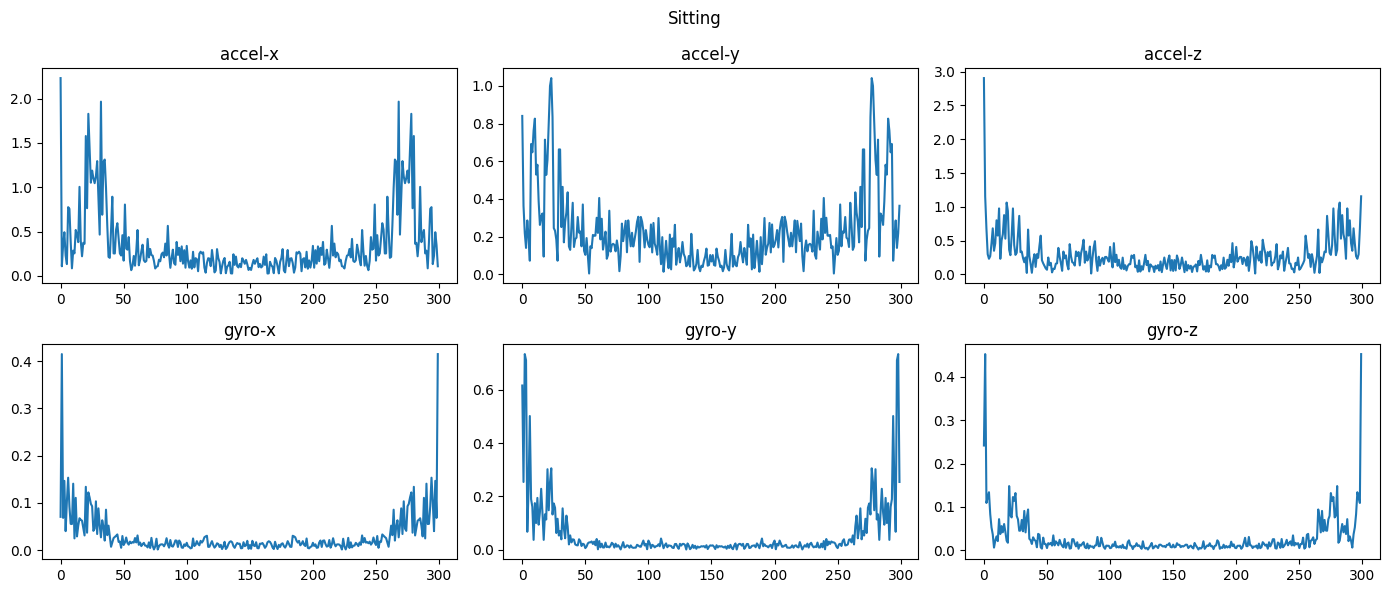

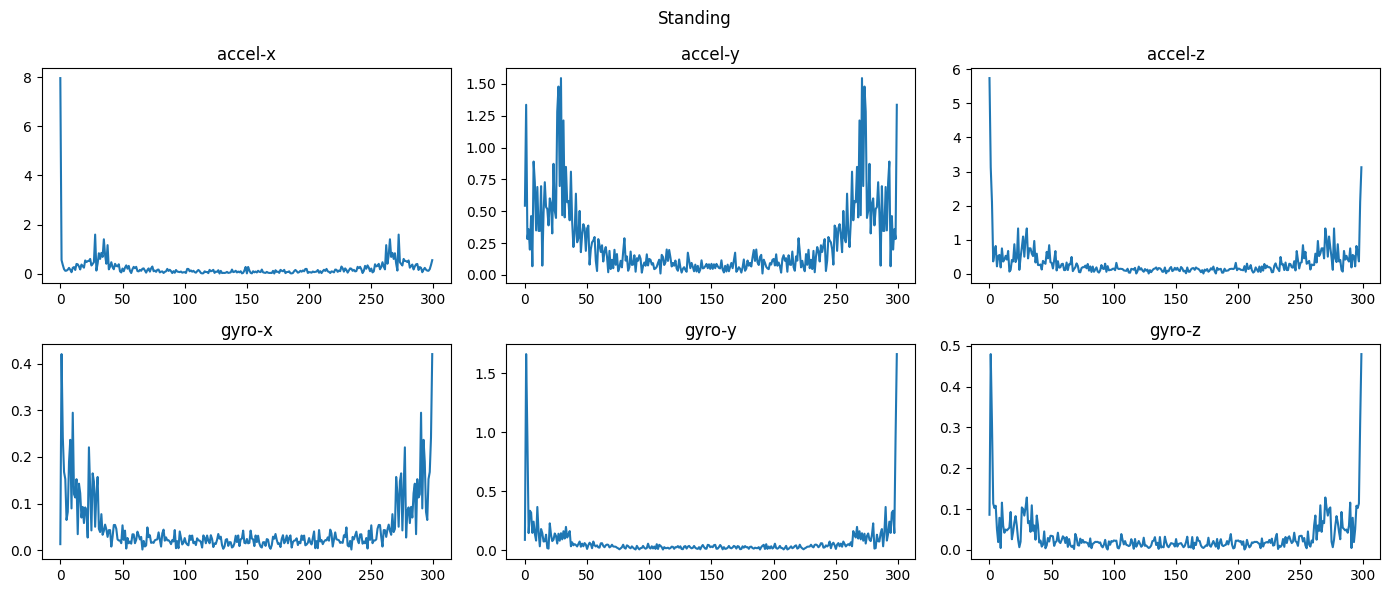

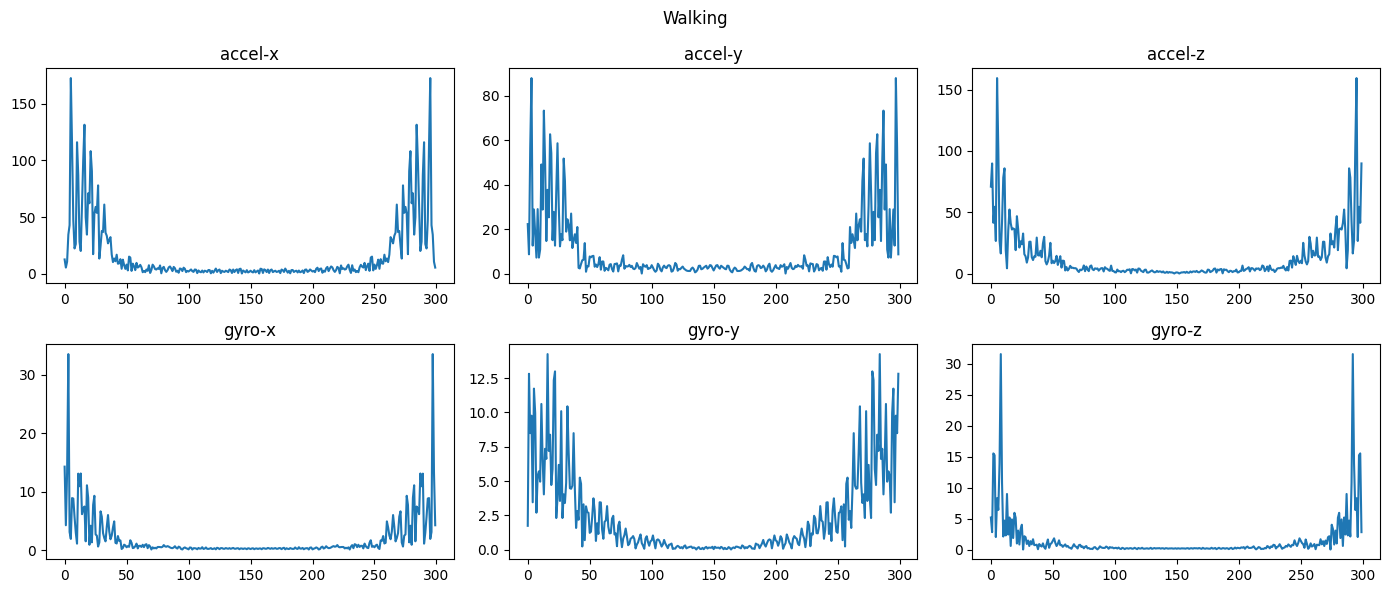

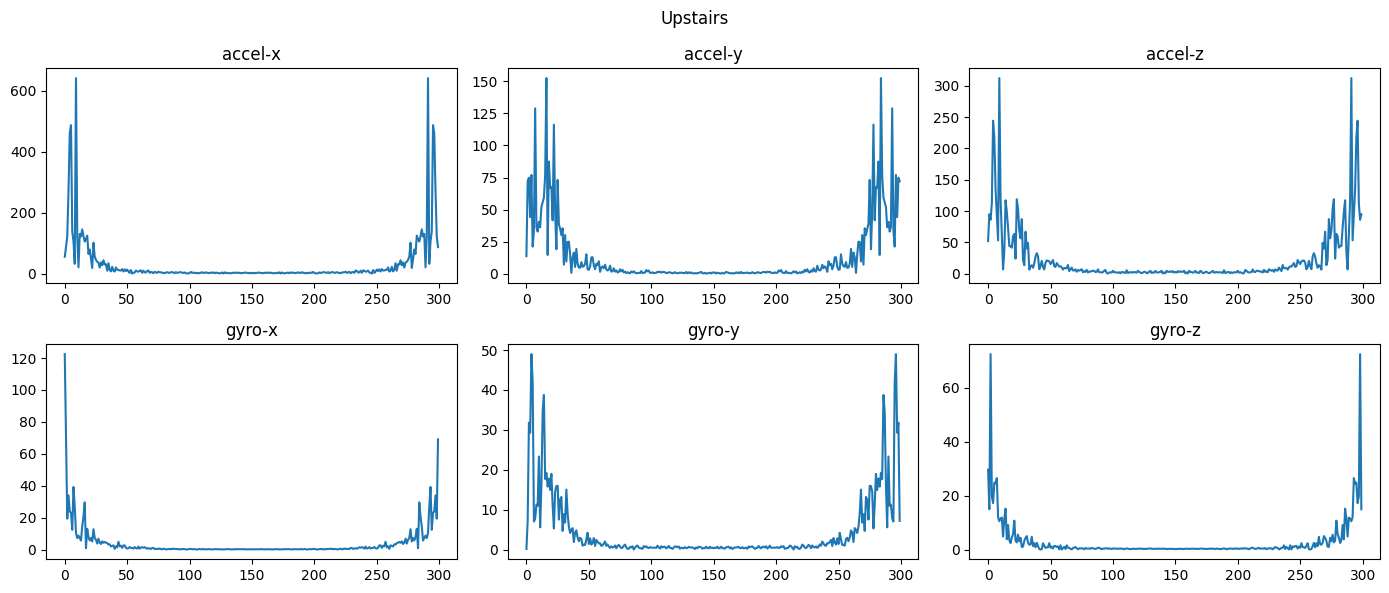

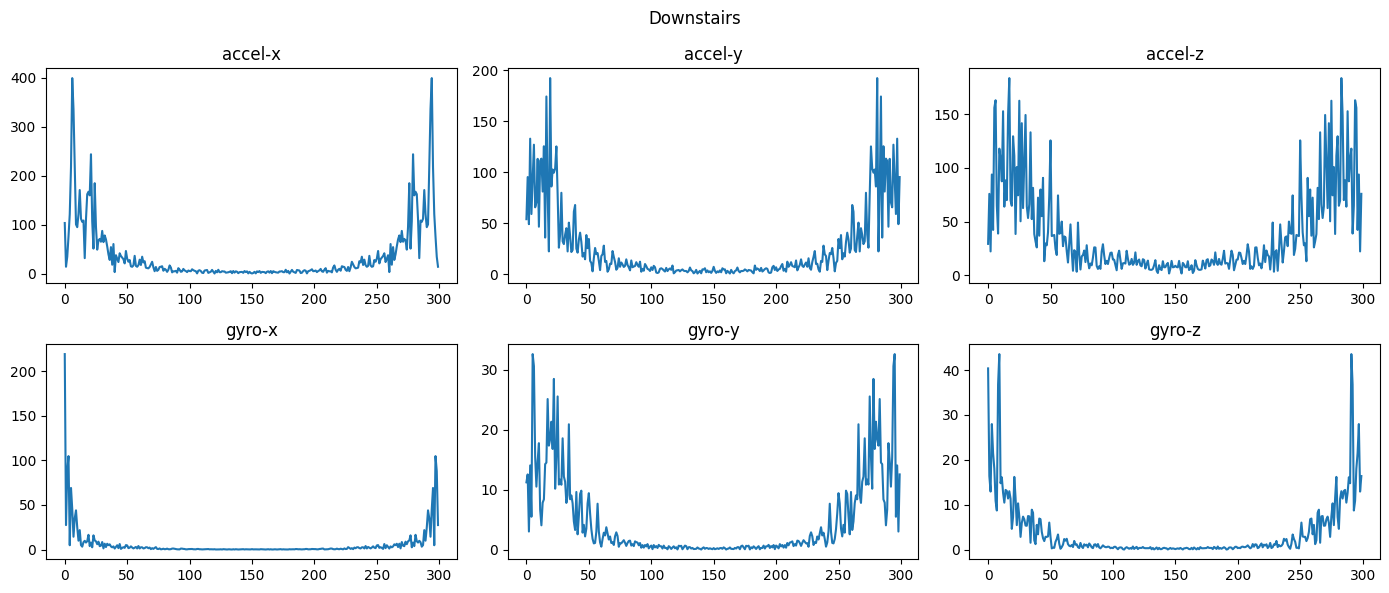

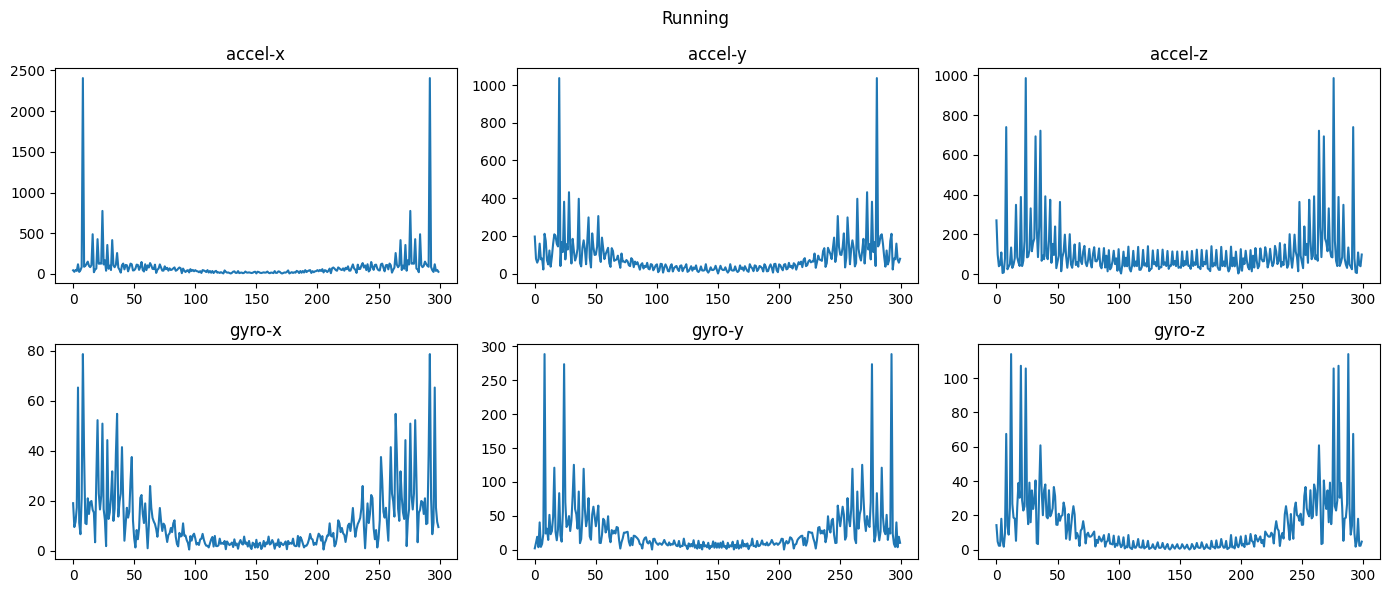

In [ ]:
def apply_dft(sample, columns_group):
    signal = sample.iloc[0][columns_group].values
    return np.fft.fft(signal)

sample_dft_list = []

def get_dft_samples():
    for code in range(len(class_names)):
        fft_data = {}
        for i, sensor_group in enumerate(sample_cols):  # 0 = accel, 1 = gyro
            for j, axis_cols in enumerate(sensor_group):  # 0 = x, 1 = y, 2 = z
                # Aplica FFT em todas as 300 amostras do eixo
                fft_result = apply_dft(sample_list[code], axis_cols)
                # Reconstruir as mesmas colunas
                for idx, col_name in enumerate(axis_cols):
                    fft_data[col_name] = np.abs(fft_result[idx])
        # Criar um novo DataFrame igual ao sample original
        fft_df = pd.DataFrame([fft_data])  # [ ] para manter 1 linha igual sample_list
        sample_dft_list.append(fft_df)

get_dft_samples()

for code in range(len(class_names)):
    plot_sample_data(sample_dft_list[code], sample_cols, code)


**COMENTÁRIO:** Agora com os sinais no domínio da frequência, o comportamento periódico torna-se mais evidente: os picos de amplitude indicam a presença de componentes harmônicas dominantes, associadas à repetição dos movimentos.

A distribuição espelhada em torno do centro é resultado da simetria complexa conjugada da DFT de sinais reais. Como o módulo (absabs) preserva essa simetria, o conteúdo de frequências negativas não adiciona nova informação. Assim, seria suficiente plotar apenas as primeiras N/2 amostras.



c) Utilizando o algoritmo t-SNE (https://www.jmlr.org/papers/v9/vandermaaten08a.html), obtenha uma visualização em duas dimensões dos dados de treinamento e validação combinados.

**Sugestão:** utilize o `plotly.express` para gerar uma figura interativa; cada amostra será um ponto no espaço bidimensional cuja cor deve indicar a atividade humana correspondente.

In [ ]:
X_train = data_train.drop(columns=['standard activity code'])
y_train = data_train['standard activity code']

X_val = data_val.drop(columns=['standard activity code'])
y_val = data_val['standard activity code']

X_test = data_test.drop(columns=['standard activity code'])
y_test = data_test['standard activity code']

In [ ]:
from sklearn import manifold

""" Vamos usar uma técnica chamada t-SNE para mapear os dados numa representação 2D de forma não-linear buscando preservar as relações
    de vizinhança (probabilística) entre as amostras.
"""
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

X_t = pd.concat([X_train, X_val])
y_t = pd.concat([y_train, y_val])
X_t_sne = t_sne.fit_transform(X_t)

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

In [ ]:
import plotly.express as px

fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=y_t, labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

## Parte 2: Aplicação de SVM

Ajuste de hiperparâmetros com busca em grade e validação cruzada (*holdout*) + aplicação ao conjunto de teste

**Nota:** para usar um conjunto de validação pré-estabelecido junto ao `GridSearchCV`, é preciso:
1. Concatenar as partições de treinamento e validação;
2. Criar uma lista de índices 0 e -1 de mesmo tamanho que o total de amostras de treinamento + validação: os 0s aparecem para as amostras de validação, e -1s para as amostras de treinamento;
3. Usar `PredefinedSplit` com a lista de índices para preparar um separador de dados de validação;
4. Passar o *splitter* através do parâmetro `cv` do `GridSearchCV`.

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler

# amostras ja estao concatenadas em X e y
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_test_scaled = scaler.transform(X_test)

#lista de índices para a separação novamente em X_train e X_val dentro do GridSearch
idx = [-1] * len(X_train) + [0] * len(X_val)

#cria o splitter de dados
splitter = PredefinedSplit(test_fold=idx)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=splitter, scoring='f1_macro')
grid.fit(X_t_scaled, y_t)

print("Best parameters found: ", grid.best_params_)
print("Métrica de avaliação: ", grid.scorer_)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
Best parameters found:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Métrica de avaliação:  make_scorer(f1_score, response_method='predict', pos_label=None, average=macro)


d) Apresente uma curva de variação de uma métrica de desempenho (e.g., $F_1$-*score*) nos dados de validação em função da largura da função *kernel* considerando a opção de *kernel* Gaussiano (ou `rbf`). Comente.

e) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.


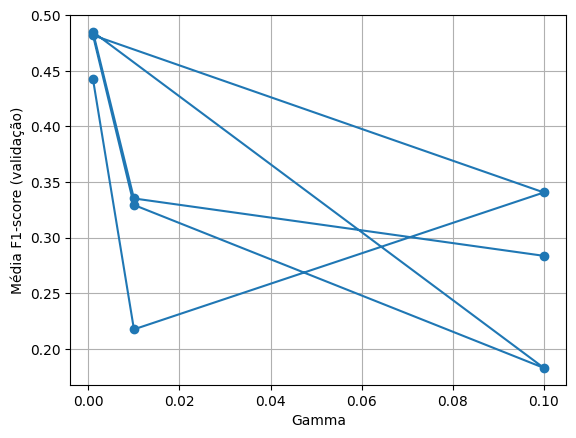

In [ ]:
# Pegando os gammas testados
gammas = grid.cv_results_['param_gamma'].data  # ou apenas .tolist()

# Pegando os F1-scores médios de validação
f1_scores = grid.cv_results_['mean_test_score']

# Plotando
plt.plot(gammas, f1_scores, marker='o')
plt.xscale('linear')
plt.xlabel('Gamma')
plt.ylabel('Média F1-score (validação)')
# plt.title('F1-score vs Gamma')
plt.grid(True)
plt.show()

 **COMENTÁRIO:** A curva evidencia que valores muito baixos de gamma (kernel largo) levam a modelos com baixa complexidade, incapazes de capturar as nuances dos dados (underfitting). Por outro lado, valores muito altos de gamma (kernel estreito) resultam em modelos altamente complexos, que se ajustam demais aos dados de treino (overfitting), prejudicando a generalização. O desempenho limitado se deve à baixa separabilidade entre as classes, especialmente entre as classes 0 e 1, que apresentam regiões de decisão sobrepostas.

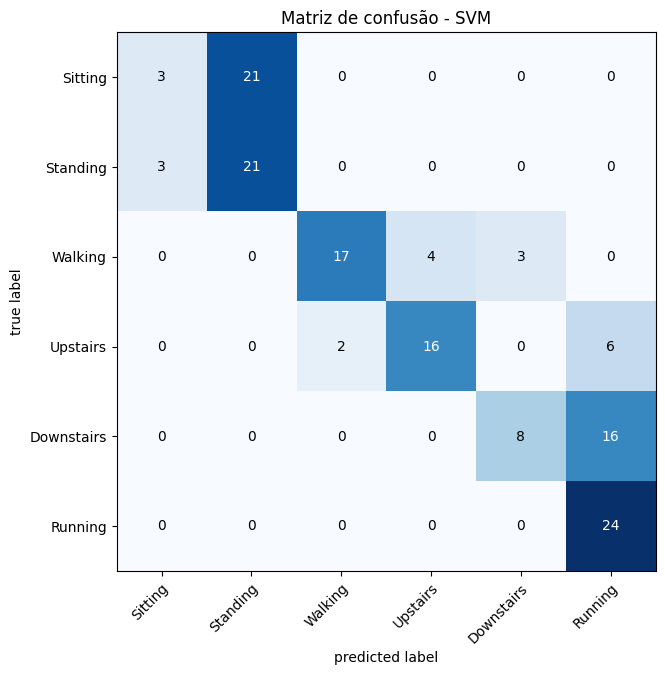

              precision    recall  f1-score   support

     Sitting       0.50      0.12      0.20        24
    Standing       0.50      0.88      0.64        24
     Walking       0.89      0.71      0.79        24
    Upstairs       0.80      0.67      0.73        24
  Downstairs       0.73      0.33      0.46        24
     Running       0.52      1.00      0.69        24

    accuracy                           0.62       144
   macro avg       0.66      0.62      0.58       144
weighted avg       0.66      0.62      0.58       144

F1-score no conjunto de teste (SVM)): 0.5829


In [ ]:
best_SVC = grid.best_estimator_

#obtém as estimativas para o conjunto de teste
SVC_pred_test = best_SVC.predict(X_test_scaled)

#exibe a matriz de confusão para o conjunto de teste
confmat = confusion_matrix(y_true=y_test, y_pred=SVC_pred_test)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - SVM')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=SVC_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste (SVM)): {f1_score(y_true=y_test, y_pred=SVC_pred_test, average='macro', zero_division=0):.4f}")

**COMENTÁRIO:** O modelo SVM teve dificuldade em distinguir algumas classes próximas, especialmente: Sitting vs Standing e Walking vs Upstairs vs Downstairs.Em resumo, o modelo separa bem Running, mas falha entre classes com padrões semelhantes de movimento ou posturas estáticas.

## Parte 3: Aplicação de kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
max_k = 5
param_grid = {
    'n_neighbors': np.arange(1,max_k+1),
    'weights': ['uniform'],
    'p': [2],
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=1,cv=splitter,scoring='f1_macro')

# Fit the model
grid.fit(X_t_scaled, y_t)

# Exibe os melhores hiperparâmetros encontrados e o score ótimo de validação
print("Best parameters found: ", grid.best_params_)
print("Métrica de avaliação: ", grid.scorer_)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
Best parameters found:  {'n_neighbors': np.int64(1), 'p': 2, 'weights': 'uniform'}
Métrica de avaliação:  make_scorer(f1_score, response_method='predict', pos_label=None, average=macro)


f) Mostre em um gráfico a variação da mesma métrica de desempenho no conjunto de validação em função do número de vizinhos ($k$). Comente.

g) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.

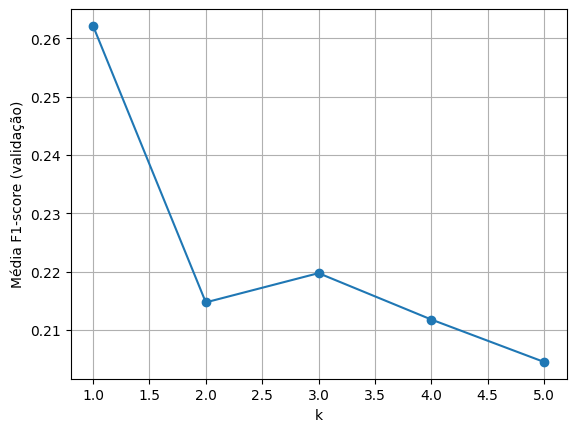

In [ ]:
# Pegando os gammas testados
k = grid.cv_results_['param_n_neighbors'].data  # ou apenas .tolist()

# Pegando os F1-scores médios de validação
f1_scores = grid.cv_results_['mean_test_score']

# Plotando
plt.plot(k, f1_scores, marker='o')
plt.xscale('linear')
plt.xlabel('k')
plt.ylabel('Média F1-score (validação)')
# plt.title('F1-score vs k')
plt.grid(True)
plt.show()

**COMENTÁRIO:** No kNN, o modelo depende da proximidade dos pontos, mas com à alta simililaridade entre as classes, ele acaba confundindo os vizinhos, comprometendo o desempenho na classificação. Por exemplo, quando k = 5, o F1-score abaixa muito porque o KNN começa a misturar mais os vizinhos de classes diferentes, tornando as previsões mais imprecisas. Ainda sim, mesmo com k = 1, o modelo não se sai bem.

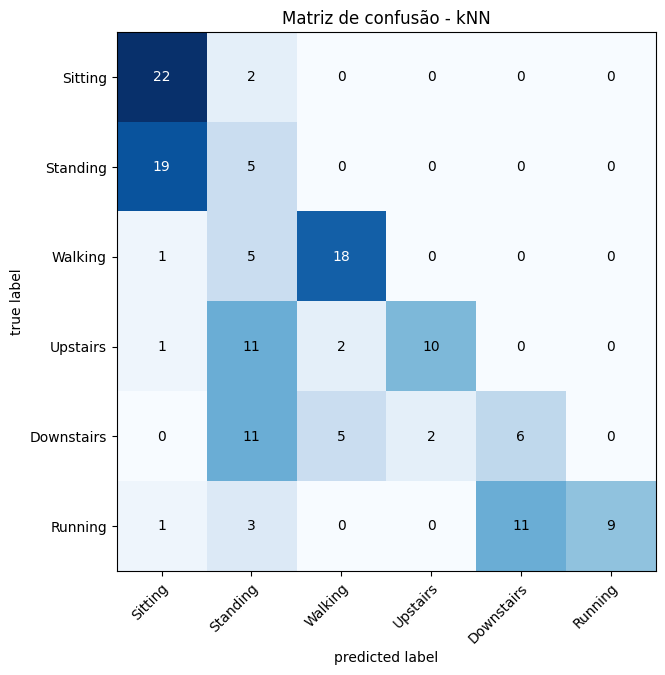

              precision    recall  f1-score   support

     Sitting       0.50      0.92      0.65        24
    Standing       0.14      0.21      0.16        24
     Walking       0.72      0.75      0.73        24
    Upstairs       0.83      0.42      0.56        24
  Downstairs       0.35      0.25      0.29        24
     Running       1.00      0.38      0.55        24

    accuracy                           0.49       144
   macro avg       0.59      0.49      0.49       144
weighted avg       0.59      0.49      0.49       144

F1-score no conjunto de teste kNN: 0.4899


In [ ]:
best_kNN = grid.best_estimator_

#obtém as estimativas para o conjunto de teste
kNN_pred_test = best_kNN.predict(X_test_scaled)

#exibe a matriz de confusão para o conjunto de teste
confmat = confusion_matrix(y_true=y_test, y_pred=kNN_pred_test)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - kNN')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=kNN_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste kNN: {f1_score(y_true=y_test, y_pred=kNN_pred_test, average='macro', zero_division=0):.4f}")

**COMENTÁRIO:** Como explicado anteriormente, há muita sobreposição de dados entre classes, o que acabou prejudicando o desempenho do modelo, que faz uso de "vizinhança" para classificação. Nota-se que para a classe Walking, o desempenho é melhor, pois está mais separada das demais, como pode ser visto no gráfico gerado a partir do t-sne.

## Parte 4: Aplicação de *Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=1, cv=splitter, scoring='f1_macro')
grid.fit(X_t, y_t)

print("Best parameters found: ", grid.best_params_)
print("Métrica de avaliação: ", grid.scorer_)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best parameters found:  {'criterion': 'gini', 'n_estimators': 200}
Métrica de avaliação:  make_scorer(f1_score, response_method='predict', pos_label=None, average=macro)


h) Mostre o impacto do número de árvores (`n_estimators`) sobre o desempenho de validação considerando como função de impureza (`criterion`) o índice de Gini e a entropia. Comente.

i) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.

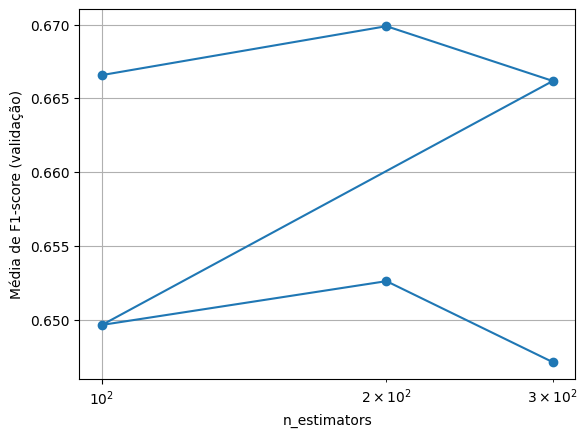

In [ ]:
cv_frame = pd.DataFrame(grid.cv_results_)

plt.plot(cv_frame['param_n_estimators'], cv_frame['mean_test_score'].values, marker='o')
plt.grid(True)
plt.xscale('log')
plt.xlabel('n_estimators')
plt.ylabel('Média de F1-score (validação)')
plt.show()

**COMENTÁRIO:** O Grid Search indicou que a melhor configuração foi com 200 estimadores e critério de impureza Gini. Usando 100 e 300 estimadores, o desempenho é semelhante e ligeiramente inferior. Isso sugere que aumentar o número de estimadores além de um certo ponto não melhora o desempenho.

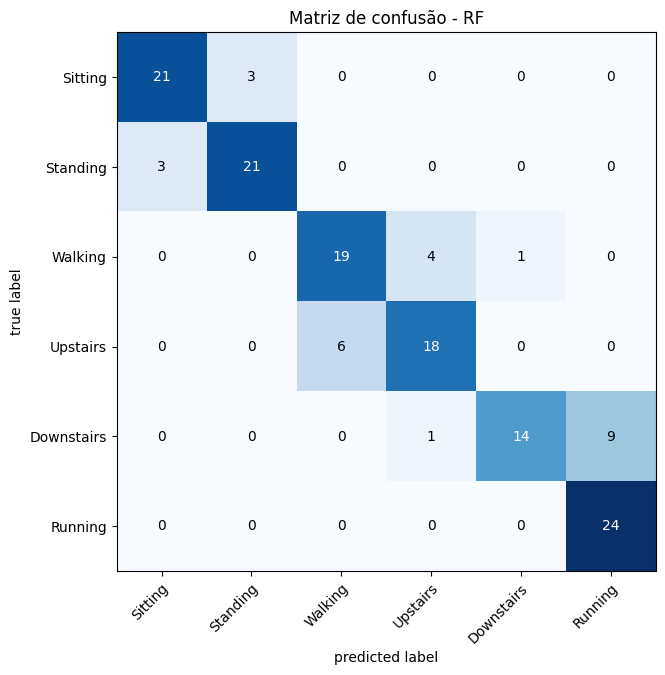

              precision    recall  f1-score   support

     Sitting       0.88      0.88      0.88        24
    Standing       0.88      0.88      0.88        24
     Walking       0.76      0.79      0.78        24
    Upstairs       0.78      0.75      0.77        24
  Downstairs       0.93      0.58      0.72        24
     Running       0.73      1.00      0.84        24

    accuracy                           0.81       144
   macro avg       0.83      0.81      0.81       144
weighted avg       0.83      0.81      0.81       144

F1-score no conjunto de teste RF: 0.8086


In [ ]:
best_RF = grid.best_estimator_

#obtém as estimativas para o conjunto de teste
RF_pred_test = best_RF.predict(X_test)

#exibe a matriz de confusão para o conjunto de teste
confmat = confusion_matrix(y_true=y_test, y_pred=RF_pred_test)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - RF')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=RF_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste RF: {f1_score(y_true=y_test, y_pred=RF_pred_test, average='macro', zero_division=0):.4f}")

**COMENTÁRIO:** Apesar das confusões entre algumas classes similares, o modelo Random Forest alcançou um F1-score de 0,8086, indicando bom desempenho geral na classificação das atividades, com maior dificuldade nas classes com padrões mais próximos, como Walking/Upstairs e Downstairs/Running.


## Parte 5: Extensão para outros dois *datasets*



j) Repita o procedimento adotado nas Partes 1 a 4 para outros dois *datasets* de sua escolha contidos no DAGHAR. Ao final de todos os passos, mostre numa tabela os desempenhos de teste alcançados pelos modelos nos três *datasets*.

**MotionSense Analysis:**

In [8]:
#Caminho para a pasta que conterá o dataset
folder = "MotionSense" # KuHar, MotionSense, RealWorld_thigh
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

#Limpeza dos datasets
dfs = [data_train, data_val, data_test]
for x in dfs:
    x.drop(columns=['user', 'index',
       'serial', 'csv', 'activity code', 'window'], inplace=True)

#Particionamento
X_train = data_train.drop(columns=['standard activity code'])
y_train = data_train['standard activity code']

X_val = data_val.drop(columns=['standard activity code'])
y_val = data_val['standard activity code']

X_test = data_test.drop(columns=['standard activity code'])
y_test = data_test['standard activity code']

#Concatenacao e normalizacao
X_t = pd.concat([X_train, X_val])
y_t = pd.concat([y_train, y_val])

scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_test_scaled = scaler.transform(X_test)

#Criacao do splitter
idx = [-1] * len(X_train) + [0] * len(X_val)
splitter = PredefinedSplit(test_fold=idx)

In [14]:
# t-sne

t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

X_t_sne = t_sne.fit_transform(X_t)

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=y_t, labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

Fitting 1 folds for each of 9 candidates, totalling 9 fits


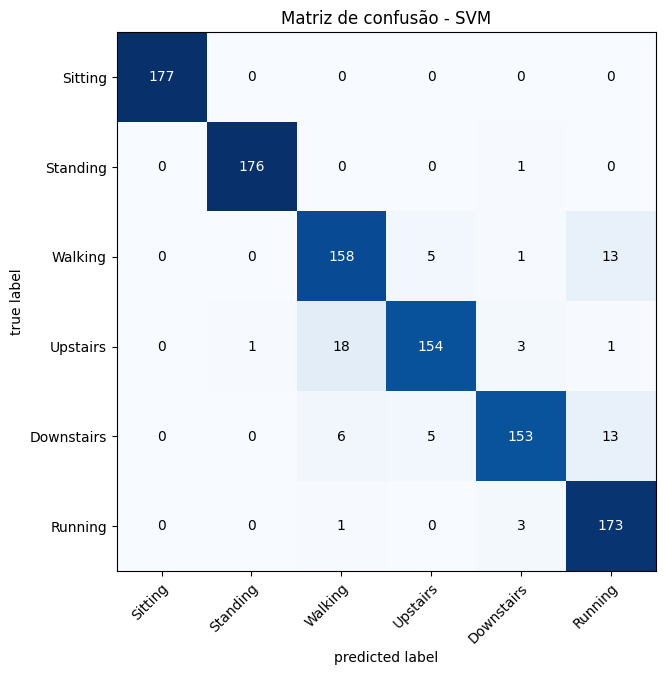

              precision    recall  f1-score   support

     Sitting       1.00      1.00      1.00       177
    Standing       0.99      0.99      0.99       177
     Walking       0.86      0.89      0.88       177
    Upstairs       0.94      0.87      0.90       177
  Downstairs       0.95      0.86      0.91       177
     Running       0.86      0.98      0.92       177

    accuracy                           0.93      1062
   macro avg       0.94      0.93      0.93      1062
weighted avg       0.94      0.93      0.93      1062

F1-score no conjunto de teste (SVM)): 0.9331


In [ ]:
#SVC - GridSearch, Predict e Plots
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=splitter, scoring='f1_macro')
grid.fit(X_t_scaled, y_t)

best_SVC = grid.best_estimator_
SVC_pred_test = best_SVC.predict(X_test_scaled)

confmat = confusion_matrix(y_true=y_test, y_pred=SVC_pred_test)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat,
    class_names=class_names,
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - SVM')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=SVC_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste (SVM)): {f1_score(y_true=y_test, y_pred=SVC_pred_test, average='macro', zero_division=0):.4f}")

Fitting 1 folds for each of 5 candidates, totalling 5 fits


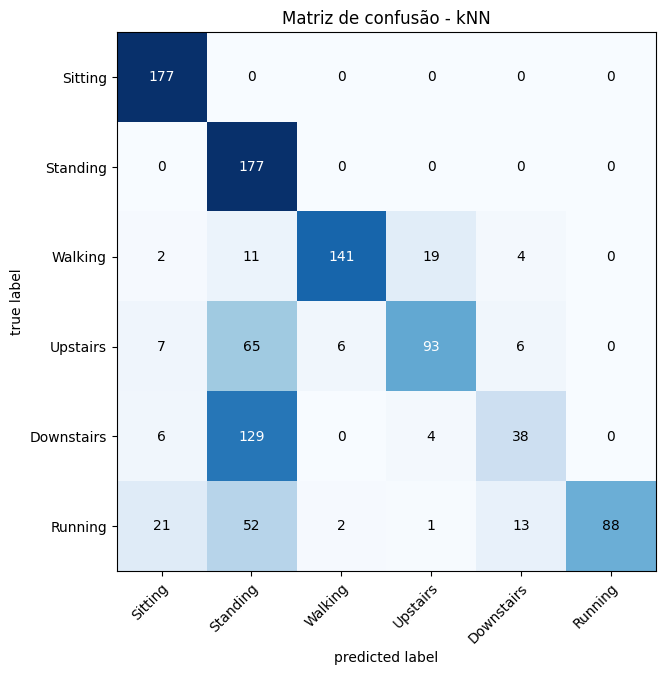

              precision    recall  f1-score   support

     Sitting       0.83      1.00      0.91       177
    Standing       0.41      1.00      0.58       177
     Walking       0.95      0.80      0.87       177
    Upstairs       0.79      0.53      0.63       177
  Downstairs       0.62      0.21      0.32       177
     Running       1.00      0.50      0.66       177

    accuracy                           0.67      1062
   macro avg       0.77      0.67      0.66      1062
weighted avg       0.77      0.67      0.66      1062

F1-score no conjunto de teste kNN: 0.6614


In [ ]:
#kNN - GridSearch, Preditct e Plots

max_k = 5
param_grid = {
    'n_neighbors': np.arange(1,max_k+1),
    'weights': ['uniform'],
    'p': [2],
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=1,cv=splitter,scoring='f1_macro')
grid.fit(X_t_scaled, y_t)

best_kNN = grid.best_estimator_
kNN_pred_test = best_kNN.predict(X_test_scaled)

confmat = confusion_matrix(y_true=y_test, y_pred=kNN_pred_test)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat,
    class_names=class_names,
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - kNN')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=kNN_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste kNN: {f1_score(y_true=y_test, y_pred=kNN_pred_test, average='macro', zero_division=0):.4f}")

Fitting 1 folds for each of 6 candidates, totalling 6 fits


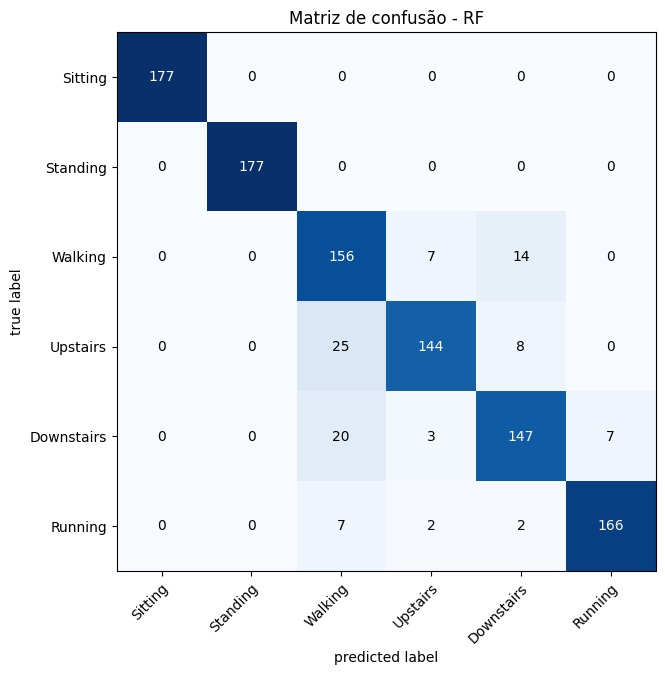

              precision    recall  f1-score   support

     Sitting       1.00      1.00      1.00       177
    Standing       1.00      1.00      1.00       177
     Walking       0.75      0.88      0.81       177
    Upstairs       0.92      0.81      0.86       177
  Downstairs       0.86      0.83      0.84       177
     Running       0.96      0.94      0.95       177

    accuracy                           0.91      1062
   macro avg       0.92      0.91      0.91      1062
weighted avg       0.92      0.91      0.91      1062

F1-score no conjunto de teste RF: 0.9114


In [ ]:
#RF - GridSearch, Preditct e Plots

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy']
}


grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=1, cv=splitter, scoring='f1_macro')
grid.fit(X_t, y_t)

best_RF = grid.best_estimator_
RF_pred_test = best_RF.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=RF_pred_test)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat,
    class_names=class_names,
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - RF')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=RF_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste RF: {f1_score(y_true=y_test, y_pred=RF_pred_test, average='macro', zero_division=0):.4f}")

**Real World Thigh Analysis:**

In [15]:
#Caminho para a pasta que conterá o dataset
folder = "RealWorld_thigh" # KuHar, MotionSense, RealWorld_thigh
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

#Limpeza dos datasets
dfs = [data_train, data_val, data_test]
for x in dfs:
    x.drop(columns=['position', 'gyro-start-time', 'activity code',
       'timestamp diff', 'accel-start-time', 'index', 'user', 'window'], inplace=True)

#Particionamento
X_train = data_train.drop(columns=['standard activity code'])
y_train = data_train['standard activity code']

X_val = data_val.drop(columns=['standard activity code'])
y_val = data_val['standard activity code']

X_test = data_test.drop(columns=['standard activity code'])
y_test = data_test['standard activity code']

#Concatenacao e normalizacao
X_t = pd.concat([X_train, X_val])
y_t = pd.concat([y_train, y_val])

scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_test_scaled = scaler.transform(X_test)

#Criacao do splitter
idx = [-1] * len(X_train) + [0] * len(X_val)
splitter = PredefinedSplit(test_fold=idx)

In [16]:
# t-sne

t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

X_t_sne = t_sne.fit_transform(X_t)

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=y_t, labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

Fitting 1 folds for each of 9 candidates, totalling 9 fits


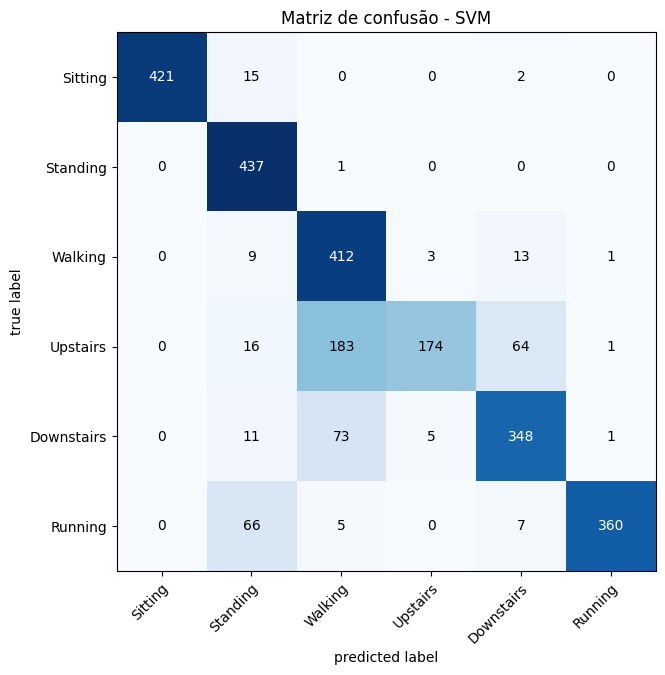

              precision    recall  f1-score   support

     Sitting       1.00      0.96      0.98       438
    Standing       0.79      1.00      0.88       438
     Walking       0.61      0.94      0.74       438
    Upstairs       0.96      0.40      0.56       438
  Downstairs       0.80      0.79      0.80       438
     Running       0.99      0.82      0.90       438

    accuracy                           0.82      2628
   macro avg       0.86      0.82      0.81      2628
weighted avg       0.86      0.82      0.81      2628

F1-score no conjunto de teste (SVM)): 0.8101


In [ ]:
#SVC - GridSearch, Predict e Plots
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=splitter, scoring='f1_macro')
grid.fit(X_t_scaled, y_t)

best_SVC = grid.best_estimator_
SVC_pred_test = best_SVC.predict(X_test_scaled)

confmat = confusion_matrix(y_true=y_test, y_pred=SVC_pred_test)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat,
    class_names=class_names,
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - SVM')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=SVC_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste (SVM)): {f1_score(y_true=y_test, y_pred=SVC_pred_test, average='macro', zero_division=0):.4f}")

Fitting 1 folds for each of 5 candidates, totalling 5 fits


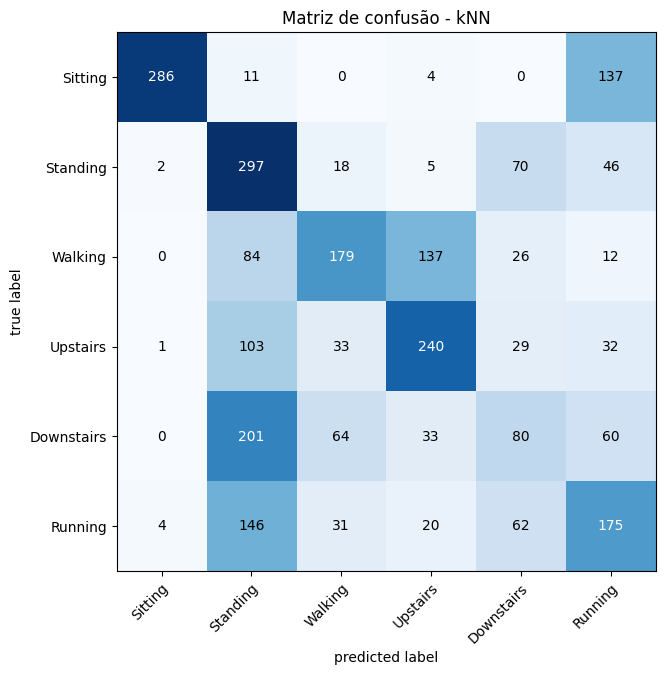

              precision    recall  f1-score   support

     Sitting       0.98      0.65      0.78       438
    Standing       0.35      0.68      0.46       438
     Walking       0.55      0.41      0.47       438
    Upstairs       0.55      0.55      0.55       438
  Downstairs       0.30      0.18      0.23       438
     Running       0.38      0.40      0.39       438

    accuracy                           0.48      2628
   macro avg       0.52      0.48      0.48      2628
weighted avg       0.52      0.48      0.48      2628

F1-score no conjunto de teste kNN: 0.4798


In [ ]:
#kNN - GridSearch, Preditct e Plots

max_k = 5
param_grid = {
    'n_neighbors': np.arange(1,max_k+1),
    'weights': ['uniform'],
    'p': [2],
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=1,cv=splitter,scoring='f1_macro')
grid.fit(X_t_scaled, y_t)

best_kNN = grid.best_estimator_
kNN_pred_test = best_kNN.predict(X_test_scaled)

confmat = confusion_matrix(y_true=y_test, y_pred=kNN_pred_test)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat,
    class_names=class_names,
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - kNN')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=kNN_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste kNN: {f1_score(y_true=y_test, y_pred=kNN_pred_test, average='macro', zero_division=0):.4f}")

Fitting 1 folds for each of 6 candidates, totalling 6 fits


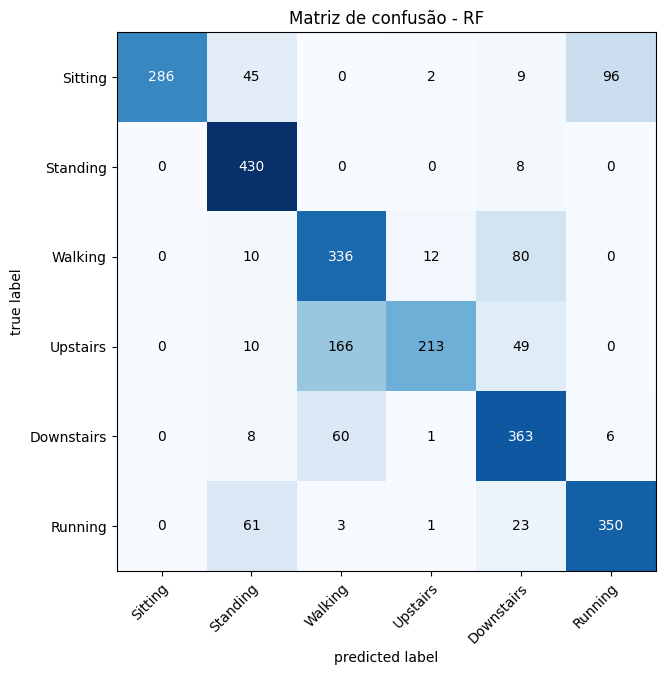

              precision    recall  f1-score   support

     Sitting       1.00      0.65      0.79       438
    Standing       0.76      0.98      0.86       438
     Walking       0.59      0.77      0.67       438
    Upstairs       0.93      0.49      0.64       438
  Downstairs       0.68      0.83      0.75       438
     Running       0.77      0.80      0.79       438

    accuracy                           0.75      2628
   macro avg       0.79      0.75      0.75      2628
weighted avg       0.79      0.75      0.75      2628

F1-score no conjunto de teste RF: 0.7487


In [ ]:
#RF - GridSearch, Preditct e Plots

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=1, cv=splitter, scoring='f1_macro')
grid.fit(X_t, y_t)

best_RF = grid.best_estimator_
RF_pred_test = best_RF.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=RF_pred_test)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat,
    class_names=class_names,
    figsize=(10,7)
)
plt.title(f'Matriz de confusão - RF')
plt.show()

print(classification_report(y_true=y_test,
                            y_pred=RF_pred_test,
                            target_names=class_names))

print(f"F1-score no conjunto de teste RF: {f1_score(y_true=y_test, y_pred=RF_pred_test, average='macro', zero_division=0):.4f}")

| Modelo | *Dataset* 1 | *Dataset* 2 | *Dataset* 3 | Média ± Desvio Padrão |
|:------:|:-----------:|:-----------:|:-----------:|:---------------------:|
| SVM    | 0.5829      | 0.9331      | 0.8101      | 0.7754 ± 0.1442       |
| kNN    | 0.4899      | 0.6614      | 0.4798      | 0.5437 ± 0.0834       |
| RF     | 0.8086      | 0.9114      | 0.7487      | 0.8229 ± 0.0663       |


k) Aplique, ao final, um teste estatístico não-paramétrico (e.g., Wilcoxon) em todos os pares de modelos - SVM vs. kNN, SVM vs. *Random Forest* e kNN vs. *Random Forest* e obtenha os p-valores. Verifique se há diferença que possa ser considerada significativa entre eles.

In [ ]:
from scipy.stats import wilcoxon

# Dados de desempenho dos modelos nos três datasets
svm = np.array([0.5829, 0.9331, 0.8101])
knn = np.array([0.4899, 0.6614, 0.4798])
rf  = np.array([0.8086, 0.9114, 0.7487])

# Testes de Wilcoxon para pares de modelos
p_svm_knn = wilcoxon(svm, knn).pvalue
p_svm_rf = wilcoxon(svm, rf).pvalue
p_knn_rf = wilcoxon(knn, rf).pvalue

print("SVM vs kNN:", p_svm_knn)
print("SVM vs Random Forest:", p_svm_rf)
print("kNN vs Random Forest:", p_knn_rf)


SVM vs kNN: 0.25
SVM vs Random Forest: 1.0
kNN vs Random Forest: 0.25


**COMENTÁRIO:** Como todos os p-valores são maiores que 0.05, não há diferenças estatisticamente significativas entre os modelos testados, dentro do nível de confiança de 95%.